# Google Colab Set up to Load Dataset

Run this if working in a Google Colab

In [9]:
!git clone https://github.com/jasonjabbour/Diffusion_Planning.git

Cloning into 'Diffusion_Planning'...
remote: Enumerating objects: 2031, done.
remote: Counting objects: 100% (2031/2031), done.
remote: Compressing objects: 100% (1039/1039), done.
remote: Total 2031 (delta 990), reused 2027 (delta 989), pack-reused 0
Receiving objects: 100% (2031/2031), 17.18 MiB | 45.22 MiB/s, done.
Resolving deltas: 100% (990/990), done.


In [5]:
%cd Diffusion_Planning

/home/jason/Desktop/Jason/Diffusion/Diffusion_Planning


In [6]:
!ls

Modeling		 unet_model_epoch_26.pth  unet_model_epoch_47.pth
PathPlanning		 unet_model_epoch_27.pth  unet_model_epoch_48.pth
README.md		 unet_model_epoch_28.pth  unet_model_epoch_49.pth
requirements.txt	 unet_model_epoch_29.pth  unet_model_epoch_4.pth
runs			 unet_model_epoch_2.pth   unet_model_epoch_50.pth
unet_model_epoch_0.pth	 unet_model_epoch_30.pth  unet_model_epoch_51.pth
unet_model_epoch_10.pth  unet_model_epoch_31.pth  unet_model_epoch_52.pth
unet_model_epoch_11.pth  unet_model_epoch_32.pth  unet_model_epoch_53.pth
unet_model_epoch_12.pth  unet_model_epoch_33.pth  unet_model_epoch_54.pth
unet_model_epoch_13.pth  unet_model_epoch_34.pth  unet_model_epoch_55.pth
unet_model_epoch_14.pth  unet_model_epoch_35.pth  unet_model_epoch_56.pth
unet_model_epoch_15.pth  unet_model_epoch_36.pth  unet_model_epoch_57.pth
unet_model_epoch_16.pth  unet_model_epoch_37.pth  unet_model_epoch_58.pth
unet_model_epoch_17.pth  unet_model_epoch_38.pth  unet_model_epoch_59.pth
unet_model_epoch_18.pth  un

# Load Dependencies

In [7]:
import torch
import pandas as pd
import numpy as np
import json
import os
import math
import matplotlib.pyplot as plt
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchvision.models as models
from torchvision import transforms

# Data Preparation

In [8]:
class PathPlanningDataset(Dataset):
    def __init__(self, csv_file, map_dir, transform=None):
        self.path_data = pd.read_csv(csv_file)
        self.map_dir = map_dir
        self.transform = transform
        self.pair_ids = self.path_data['pair_id'].unique()
        self.max_path_length = self.find_max_path_length()

    def find_max_path_length(self):
        # Find the maximum length among all RRT and A* paths
        max_length = 0
        for pair_id in self.pair_ids:
            astar_path = self.path_data[(self.path_data['pair_id'] == pair_id) & (self.path_data['algo'] == 'A*')]
            max_length = max(max_length, len(astar_path))
        return max_length

    def pad_with_eos(self, path_tensor, max_length):
        padded_path = torch.full((max_length, 2), -1.0)  # Using -1.0 as the EOS token
        length = path_tensor.size(0)
        padded_path[:length] = path_tensor
        return padded_path

    def __len__(self):
        return len(self.pair_ids)

    def __getitem__(self, idx):
        pair_id = self.pair_ids[idx]
        # Load map data
        map_path = os.path.join(self.map_dir, f'map_{pair_id}.json')
        with open(map_path, 'r') as f:
            map_data = json.load(f)

        # Load path data
        astar_path = self.path_data[(self.path_data['pair_id'] == pair_id) & (self.path_data['algo'] == 'A*')][['x', 'y']].values

        # Extracting start and end points
        start_point = astar_path[0]
        end_point = astar_path[-1]

        # Convert paths to PyTorch tensors
        astar_tensor = torch.tensor(astar_path, dtype=torch.float32)
        # Convert map to tensor
        map_tensor = torch.tensor(map_data, dtype=torch.float32)
        # Convert start_point, end_point to tensors
        start_point_tensor = torch.tensor(start_point, dtype=torch.float32)
        end_point_tensor = torch.tensor(end_point, dtype=torch.float32)

        # Pad paths with the EOS token to ensure consistent length
        astar_tensor = self.pad_with_eos(astar_tensor, self.max_path_length)

        # Create a mask for valid points in the path
        astar_mask = (astar_tensor[:, 0] != -1.0)

        return {'map': map_tensor, 'astar_path': astar_tensor, 'astar_mask': astar_mask, 'start_point': start_point_tensor, 'end_point': end_point_tensor}


def collate_fn(batch):
    maps = [item['map'] for item in batch]
    astar_paths = [item['astar_path'] for item in batch]
    astar_masks = [item['astar_mask'] for item in batch]
    start_point = [item['start_point'] for item in batch]
    end_point = [item['end_point'] for item in batch]

    # Stack the sequences
    maps_stacked = torch.stack(maps)
    astar_padded = torch.stack(astar_paths)
    astar_masks = torch.stack(astar_masks)  # Stack masks
    start_points_stacked = torch.stack(start_point)
    end_points_stacked = torch.stack(end_point)

    return {'map': maps_stacked, 'astar_path': astar_padded, 'astar_mask': astar_masks, 'start_point': start_points_stacked, 'end_point': end_points_stacked}


# Usage
batch_size = 32
dataset = PathPlanningDataset(csv_file='PathPlanning/path_data/path_data_astar.csv', map_dir='PathPlanning/map_data')
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

Test the data loader

In [9]:
# To test the dataloader, you can iterate over it
for i, data in enumerate(dataloader):
    print(f"Batch {i}")
    print(data['map'].shape, data['astar_path'].shape, data['astar_mask'].shape)
    break

Batch 0
torch.Size([32, 100, 100]) torch.Size([32, 175, 2]) torch.Size([32, 175])


In [10]:
print(f"Number of unique paths and maps: {len(dataset)}")

Number of unique paths and maps: 1000


Merge Path and Map Function

In [11]:
def modify_map_with_path(map_matrix, path, mask=None):
    """
    Modify map_matrix with the given path, excluding coordinates where mask is False.

    Args:
    - map_matrix (np.ndarray): The map as a 2D numpy array.
    - path (list of tuples): The path as a list of (x, y) coordinates.
    - mask (np.ndarray, optional): A boolean array of the same shape as map_matrix.
                                   If provided, only the coordinates where mask is True
                                   will be marked.

    Returns:
    - np.ndarray: The modified map.


    Maps are (100,100) matrices that have 4 values.

    0: White-space no obstacle
    1: Obstacle
    2: Start
    3: End
    4: Path

    """
    modified_map = np.copy(map_matrix)
    index = 0
    for (x, y) in path:
        if 0 <= x < modified_map.shape[1] and 0 <= y < modified_map.shape[0]:
            # If a mask is provided and the mask value is False, skip marking this coordinate
            if mask is not None and not mask[index]:
                continue

            current_value = modified_map[int(y), int(x)]
            # Avoid overwriting start (2) and end (3) points
            if current_value not in {2, 3}:
                modified_map[int(y), int(x)] = 4  # Mark the path

        index+=1

    return modified_map

Visualize Merged Path and Map

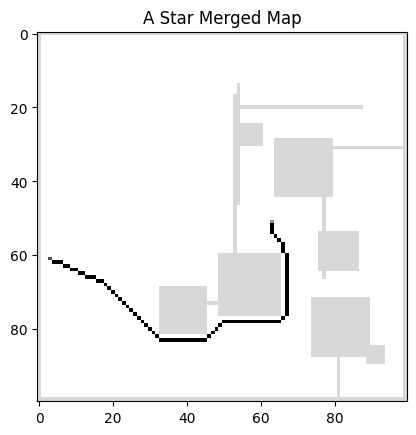

In [12]:
# Get a batch of data
data = next(iter(dataloader))
maps = data['map']

# Modify the maps with the RRT paths
modified_maps = []
for i in range(maps.size(0)):
    astar_modified_map = modify_map_with_path(maps[i].numpy(), data['astar_path'][i].numpy(), data['astar_mask'][i].numpy())
    break

# Visualize the first generated map
plt.imshow(astar_modified_map.squeeze(), cmap='Greys')
plt.title("A Star Merged Map")
plt.show()

# Modeling

## Extract Feature Embeddings from Maps using Resnet

Map Preprocessing Function

In [13]:
def preprocess_maps(maps):
    # Resize maps and adjust channels for ResNet
    # ResNet expects 3-channel images, but your maps are 1-channel.
    # You need to repeat the channels to make it 3-channel, and also resize to at least 224x224 as expected by ResNet.
    # Check if maps is missing a spatial dimension

    # Check if maps already include a batch dimension
    if maps.dim() == 3:  # Shape is (N, H, W), typical for batched grayscale images
        maps = maps.unsqueeze(1)  # Add a channel dimension: (N, 1, H, W)
    elif maps.dim() == 2:  # Single image (H, W)
        maps = maps.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions: (1, 1, H, W)
    elif maps.dim() == 4 and maps.size(1) == 1:  # Already in (N, C, H, W) format
        pass  # No need to change anything if already properly shaped
    else:
        raise ValueError("Unexpected map dimensions. Expected (H, W), (N, H, W), or (N, C, H, W) with C=1")

    # Resize maps to the expected input size of the ResNet (224x224) and repeat the single channel to simulate 3 channels
    maps_resized = torch.nn.functional.interpolate(maps, size=(224, 224), mode='bilinear', align_corners=False)
    maps_resized = maps_resized.repeat(1, 3, 1, 1)  # Repeat the channel dimension to create 3-channel images

    return maps_resized

Load ResNet Feature Extractor

In [14]:
# Load the pretrained ResNet model
pretrained_resnet18_model = models.resnet18(pretrained=True)

# Remove the fully connected layer to use the model as a feature extractor
resnet18_feature_extractor = nn.Sequential(*list(pretrained_resnet18_model.children())[:-1])

/home/jason/anaconda3/envs/diffusion_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jason/anaconda3/envs/diffusion_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Example showing embeddings for input

In [15]:
# Iterate over the DataLoader (process only the first batch for demonstration)
for i, batch in enumerate(dataloader):
    maps, astar_paths = batch['map'], batch['astar_path']

    # Resize maps for the resnet model
    maps_resized = preprocess_maps(maps)

    # Forward pass through the modified model to get the embeddings
    embeddings = resnet18_feature_extractor(maps_resized)

    break

# Check the shape of the output embeddings
print(embeddings.shape)

torch.Size([32, 512, 1, 1])


# Diffusion Model

In [16]:
# Check if CUDA is available and set the device accordingly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda:0


Build Diffusion Model Architecture


In [17]:
class DiffusionModel:
    def __init__(self, start_schedule=0.0001, end_schedule=0.01, timesteps = 150):
        # start_schedule: starting value for beta scheduling
        self.start_schedule = start_schedule
        # end_schedule: ending value for beta scheduling
        self.end_schedule = end_schedule
        # timesteps: number of timesteps in the diffusion process
        self.timesteps = timesteps

        """
        if
            betas = [0.1, 0.2, 0.3, ...]
        then
            alphas = [0.9, 0.8, 0.7, ...]
            alphas_cumprod = [0.9, 0.9 * 0.8, 0.9 * 0.8, * 0.7, ...]


        """
        # Create an array of beta values linearly spaced between start and end schedules
        self.betas = torch.linspace(start_schedule, end_schedule, timesteps)
        # Compute alpha values as 1 minus the corresponding beta values
        self.alphas = 1 - self.betas
        # Compute the cumulative product of alphas to use in diffusion calculations
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        # Scaling factor for noise
        self.noise_scale = 20.0

    def forward(self, x_0, t, mask, device):
        """
        Simulate the forward diffusion process (noising)

        x_0: original path data (Batch, Channel, Height, Width)
        t: timestep indices for the diffusion (Batch,)
        mask: Boolean tensor indicating valid path points.
        """
        # Generate noise with the same shape as the input data
        noise = torch.randn_like(x_0) * self.noise_scale
        # Get the square root of alphas_cumprod for the given timesteps
        sqrt_alphas_cumprod_t = self.get_index_from_list(self.alphas_cumprod.sqrt(), t, x_0.shape)
        # Get the square root of (1 - alphas_cumprod) for the given timesteps
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x_0.shape)

        # Calculate the mean of the diffusion process at time t
        mean = sqrt_alphas_cumprod_t.to(device) * x_0.to(device)
        # Calculate the variance contribution from the noise
        variance = sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device)

        # Calculate final noisy output, ensuring EOS (-1) tokens remain unchanged
        noisy_output = mean + variance
        noisy_output = torch.where(mask.unsqueeze(-1).to(device), noisy_output, torch.full_like(noisy_output, -1.0))

        # Return the noisy version of the input along with the generated noise
        return noisy_output, noise.to(device)


    @torch.no_grad()
    def backward(self, x, t, map_embeddings, model, device):
        """
        Simulate the reverse diffusion process (denoising)

        Calls the model to predict the noise in the path and returns
        the denoised path.
        Applies noise to this path, if we are not in the last step yet.

        x: current noisy path
        t: timestep indices
        model: model used to estimate the original noise in the path
        """

        # Get model predictions for noise at each timestep
        predicted_noise = model(x, map_embeddings, t)
        
        # Extract the beta value for each timestep
        betas_t = self.get_index_from_list(self.betas, t, x.shape)
        # Compute necessary components for the denoising step
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x.shape)
        sqrt_recip_alphas_t = self.get_index_from_list(torch.sqrt(1.0 / self.alphas), t, x.shape)

        # Calculate the mean of the denoised image
        mean = sqrt_recip_alphas_t * (x - betas_t * predicted_noise / sqrt_one_minus_alphas_cumprod_t)
        posterior_variance_t = betas_t

        # Add noise only if not the last timestep
        if (t > 0).all():
            noise = torch.randn_like(x)
            variance = torch.sqrt(posterior_variance_t) * noise
            return mean + variance
        else:
            return mean

    @staticmethod
    def get_index_from_list(values, t, x_shape):
        batch_size = t.shape[0]
        """
        Static method to extract values from a tensor based on indices
        and reshape the result to match input dimensions

        pick the values from vals
        according to the indices stored in `t`
        """
        # Gather the values from `values` tensor at indices provided by `t`
        result = values.gather(-1, t.cpu())
        """
        if
        x_shape = (5, 3, 64, 64)
            -> len(x_shape) = 4
            -> len(x_shape) - 1 = 3

        and thus we reshape `out` to dims
        (batch_size, 1, 1, 1)

        """
        # Reshape the result to match the input dimensions for broadcasting
        return result.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)



In [18]:
# No resize needed, no scaling between [-1, 1] since it's not image color data
transform = transforms.Compose([
    transforms.ToTensor(), # Directly convert to tensor
])

reverse_transform = transforms.Compose([
    transforms.Lambda(lambda t: t.permute(1, 2, 0)),  # Convert CHW to HWC for visualization
])

In [19]:
# Helper function to get a sample map and path
def get_sample_map_and_path(dataset):
    sample_data = next(iter(DataLoader(dataset, batch_size=1, shuffle=True)))
    return sample_data['map'].squeeze(0), sample_data['astar_path'].squeeze(0), sample_data['astar_mask'].squeeze(0)

Forward Process Visualization

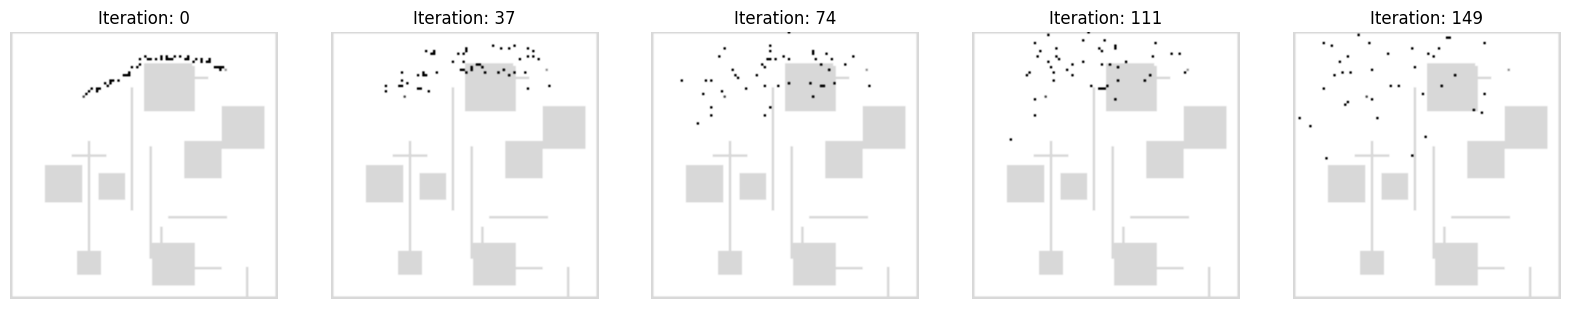

In [20]:
# Get a sample map and path
map_tensor, path_tensor, mask_tensor = get_sample_map_and_path(dataset)

# Initialize Diffusion model
diffusion_model = DiffusionModel()

# Pretend we're processing multiple timesteps at once for illustration
NO_DISPLAY_IMAGES = 5

# Stack the path data for processing multiple timesteps
path_batch = path_tensor.unsqueeze(0).repeat(NO_DISPLAY_IMAGES, 1, 1)

# Generate timesteps evenly spaced across the diffusion process
t = torch.linspace(0, diffusion_model.timesteps - 1, NO_DISPLAY_IMAGES).long()

# Get a batch of noised paths
noisy_path_batch, _ = diffusion_model.forward(path_batch, t, mask_tensor, device)

# Visualization setup
f, ax = plt.subplots(1, NO_DISPLAY_IMAGES, figsize=(20, 4))

for idx, noisy_path in enumerate(noisy_path_batch):
    # Convert tensor back to numpy for plotting
    noisy_path_np = noisy_path.cpu().numpy()

    # Create a copy of the map to modify
    modified_map = np.copy(map_tensor.numpy())

    # Use your function to modify the map with the path
    noised_path_modified_map = modify_map_with_path(map_tensor.numpy(), noisy_path_np, mask=mask_tensor)

    ax[idx].imshow(noised_path_modified_map, cmap='Greys')
    ax[idx].set_title(f"Iteration: {t[idx].item()}")
    ax[idx].axis('off')

plt.show()

Unet

In [21]:
class SinusoidalPositionEmbeddings(nn.Module):
    """
      Class for generating sinusoidal position embeddings based on the input time step
    """
    def __init__(self, dim):
        super().__init__()
         # Dimensionality of the time embeddings
        self.dim = dim

    def forward(self, time):
        # Get the device (CPU/GPU) of the input tensor
        device = time.device
        # Divide the embedding dimension in half
        half_dim = self.dim // 2
        # Scaling factor for the embeddings
        embeddings = math.log(10000) / (half_dim - 1)
        # Generate exponential steps
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
         # Scale the steps by the input time tensor
        embeddings = time[:, None] * embeddings[None, :]
         # Apply sine and cosine
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # Return the final time embedding
        return embeddings

Sinusoidal Embeddings Example

Time step 0: Embedding: tensor([[0., 0., 0., 0., 0., 1., 1., 1., 1., 1.]])
Time step 1: Embedding: tensor([[2.4740e-01, 2.4997e-02, 2.5000e-03, 2.5000e-04, 2.5000e-05, 9.6891e-01,
         9.9969e-01, 1.0000e+00, 1.0000e+00, 1.0000e+00]])
Time step 2: Embedding: tensor([[4.7943e-01, 4.9979e-02, 5.0000e-03, 5.0000e-04, 5.0000e-05, 8.7758e-01,
         9.9875e-01, 9.9999e-01, 1.0000e+00, 1.0000e+00]])
Time step 3: Embedding: tensor([[6.8164e-01, 7.4930e-02, 7.4999e-03, 7.5000e-04, 7.5000e-05, 7.3169e-01,
         9.9719e-01, 9.9997e-01, 1.0000e+00, 1.0000e+00]])
Time step 4: Embedding: tensor([[8.4147e-01, 9.9833e-02, 9.9998e-03, 1.0000e-03, 1.0000e-04, 5.4030e-01,
         9.9500e-01, 9.9995e-01, 1.0000e+00, 1.0000e+00]])


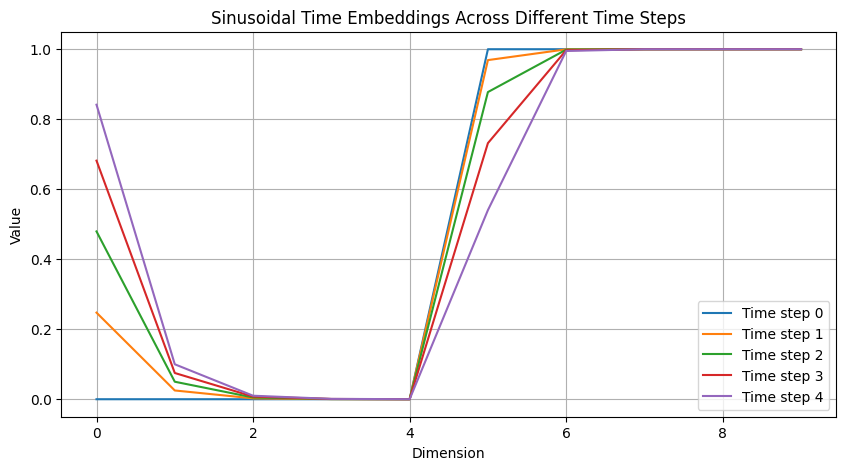

In [22]:
# Initialize the embedding generator
embedding_generator = SinusoidalPositionEmbeddings(dim=10)
# Generate time steps (for example, 5 time steps) Normalized time steps from 0 to 1
timesteps = torch.linspace(0, 1,5)
# Generate embeddings for each time step
time_embeddings = [embedding_generator.forward(timestep.unsqueeze(0)) for timestep in timesteps]

# Print the embeddings
for idx, embedding in enumerate(time_embeddings):
    print(f"Time step {idx}: Embedding: {embedding}")

plt.figure(figsize=(10, 5))
for i, embedding in enumerate(time_embeddings):
    plt.plot(embedding[0].numpy(), label=f'Time step {i}')
plt.title('Sinusoidal Time Embeddings Across Different Time Steps')
plt.xlabel('Dimension')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [23]:

class Block(nn.Module):
    def __init__(self, channels_in, channels_out, time_embedding_dims, num_filters=3, downsample=True):
        super().__init__()
        # Time embedding module
        self.time_embedding = SinusoidalPositionEmbeddings(time_embedding_dims)
        # Kernel size for the convolutions
        kernel_size = 3
        # Stride for downsampling
        stride = 2 if downsample else 1
        # Padding to keep dimensions consistent
        padding = 1
        # First convolution layer
        self.conv1 = nn.Conv1d(channels_in, channels_out, kernel_size, padding=padding)
        # Second convolution layer
        self.conv2 = nn.Conv1d(channels_out, channels_out, kernel_size, padding=padding)
        # MLP for processing time embeddings
        self.time_mlp = nn.Linear(time_embedding_dims, channels_out)
        # ReLU activation function
        self.relu = nn.ReLU()

    def forward(self, x, t):
        # Apply the first convolution and activation
        x = self.relu(self.conv1(x))
        # Generate and process time embeddings
        time_emb = self.time_mlp(self.time_embedding(t))
        # Expand time embeddings to match data dimensions
        time_emb = time_emb.unsqueeze(-1).expand_as(x)
        # Add time information to the features
        x = x + time_emb
        # Apply the second convolution and activation
        x = self.relu(self.conv2(x))
        # Return the processed features
        return x

class UNet(nn.Module):
    def __init__(self, input_channels, map_emb_dims, time_embedding_dims, sequence_channels=(64, 128, 256, 512, 1024)):
        super().__init__()
        # Initial convolution layer
        # Adjust the input channels to account for concatenated map embeddings and path data
        self.conv1 = nn.Conv1d(input_channels + map_emb_dims, sequence_channels[0], 3, padding=1)
        # Create a series of Blocks for processing features
        self.blocks = nn.ModuleList([Block(channels_in, channels_out, time_embedding_dims) for channels_in, channels_out in zip(sequence_channels[:-1], sequence_channels[1:])])
        # Output 2 channels for X and Y coordinates
        self.final_conv = nn.Conv1d(sequence_channels[-1], 2, 1)

    def forward(self, path_data, map_embeddings, t):
        # Expand and repeat map embeddings to match path data dimensions
        map_features = map_embeddings.unsqueeze(-1).repeat(1, 1, path_data.size(2))
        # Concatenate map features with path data
        x = torch.cat((path_data, map_features), dim=1)
        # Apply the initial convolution to the input
        x = self.conv1(x)
        # Pass the features through each block
        for block in self.blocks:
            x = block(x, t)
        # Return the final coordinates after the last convolution
        # This is supposed to predict the amount of noise added to each x and y value.
        return self.final_conv(x)

# Example usage
map_emb_dims = 512
input_channels = 2  # For the path data (x, y)
time_embedding_dims = 128
model = UNet(input_channels, map_emb_dims, time_embedding_dims)

# Dummy data
batch_size = 32
sequence_length = 175
# Map embeddings
map_embeddings = torch.rand(batch_size, map_emb_dims)
# Noised path data (batch, xy, sequence_length)
noised_path = torch.rand(batch_size, 2, sequence_length)
# Uniform time steps for simplicity
time_steps = torch.tensor([0.5] * batch_size)

# Forward pass
output = model(noised_path, map_embeddings, time_steps)
# Should be [batch_size, 2, sequence_length]
print(output.shape)

torch.Size([32, 2, 175])


In [24]:
def visualize_forward_diffusion(num_timestep_display, original_path, noisy_path_timesteps_batch, sample_map, sample_mask, t):
    fig, ax = plt.subplots(1, num_timestep_display + 1, figsize=(20, 4))

    # Plot original path
    original_modified_map = modify_map_with_path(np.copy(sample_map.cpu().numpy()), original_path.cpu().numpy(), sample_mask.cpu().numpy())
    ax[0].imshow(original_modified_map, cmap='Greys')
    ax[0].set_title("Original Path")
    ax[0].axis('off')

    # Plot noised paths
    for idx, noisy_path in enumerate(noisy_path_timesteps_batch):
        noisy_path_np = noisy_path.cpu().numpy()
        noised_path_modified_map = modify_map_with_path(np.copy(sample_map.cpu().numpy()), noisy_path_np, sample_mask.cpu().numpy())
        ax[idx + 1].imshow(noised_path_modified_map, cmap='Greys')
        ax[idx + 1].set_title(f"Noised Path\nTime Step: {t[idx].item()}")
        ax[idx + 1].axis('off')

    plt.show()


def visualize_denoised_paths(num_timestep_display, original_path, denoised_path_timesteps_batch, sample_map, sample_mask, t):
    # Ensure the figure has the right number of subplots
    fig, ax = plt.subplots(1, num_timestep_display + 1, figsize=(20, 4))

    # Plot the original path only once, on the first subplot
    original_modified_map = modify_map_with_path(np.copy(sample_map.cpu().numpy()), original_path.cpu().numpy(), sample_mask.cpu().numpy())
    ax[0].imshow(original_modified_map, cmap='Greys')
    ax[0].set_title("Original Path")
    ax[0].axis('off')

    # Plot noised and denoised paths for each timestep
    for idx, denoised_path in enumerate(denoised_path_timesteps_batch):
        denoised_path_np = denoised_path.cpu().numpy()

        # Denoised path
        denoised_path_modified_map = modify_map_with_path(np.copy(sample_map.cpu().numpy()), denoised_path_np, sample_mask.cpu().numpy())
        ax[idx + 1].imshow(denoised_path_modified_map, cmap='Greys')
        ax[idx + 1].set_title(f"Denoised Path\nTime Step: {t[idx]}")
        ax[idx + 1].axis('off')

    plt.show()

# Training

/home/jason/anaconda3/envs/diffusion_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jason/anaconda3/envs/diffusion_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/jason/anaconda3/envs/diffusion_env/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/

Epoch: 0 | Train Loss: 400.21332836151123


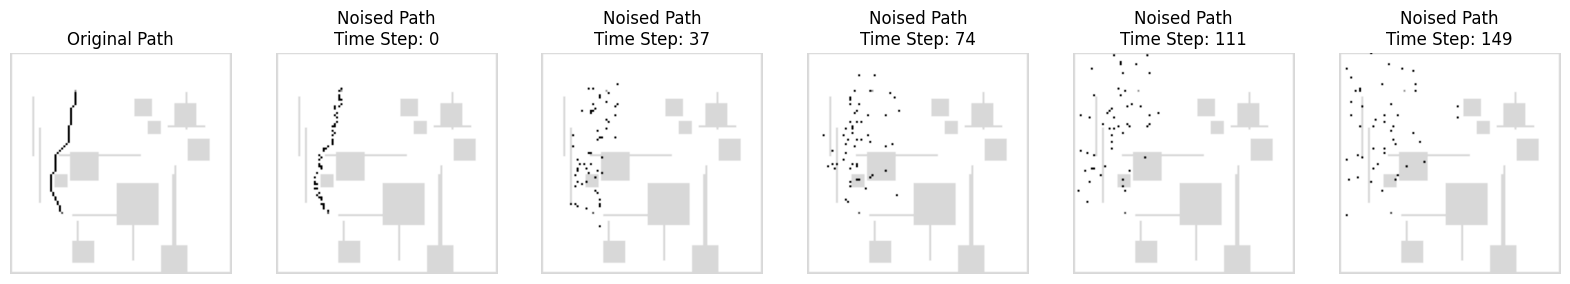

/home/jason/anaconda3/envs/diffusion_env/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


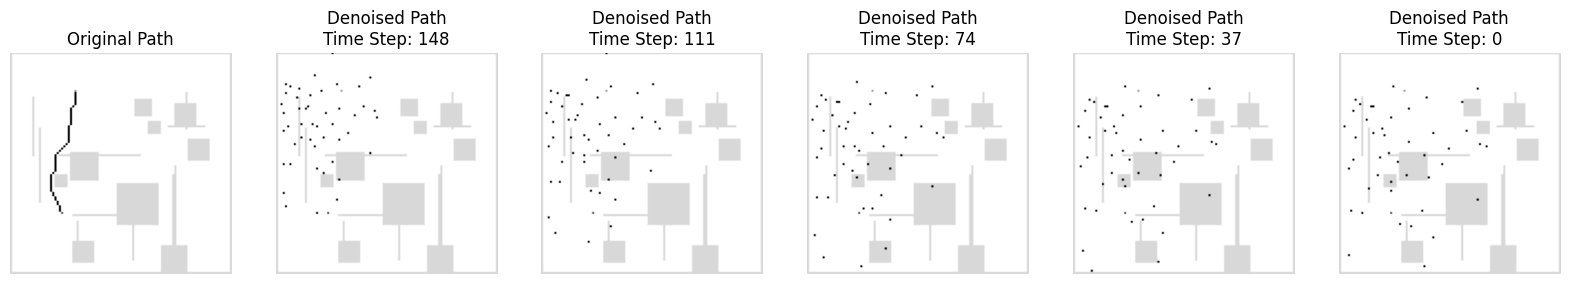

Epoch: 1 | Train Loss: 391.2477321624756
Epoch: 2 | Train Loss: 347.3867254257202
Epoch: 3 | Train Loss: 309.8780813217163
Epoch: 4 | Train Loss: 278.0094633102417
Epoch: 5 | Train Loss: 269.2564482688904
Epoch: 6 | Train Loss: 265.57203006744385
Epoch: 7 | Train Loss: 260.51843643188477
Epoch: 8 | Train Loss: 258.1948661804199
Epoch: 9 | Train Loss: 255.941246509552
Epoch: 10 | Train Loss: 256.49527072906494
Epoch: 11 | Train Loss: 253.78771781921387
Epoch: 12 | Train Loss: 252.99876880645752
Epoch: 13 | Train Loss: 253.47566890716553
Epoch: 14 | Train Loss: 252.32680559158325
Epoch: 15 | Train Loss: 253.02320098876953
Epoch: 16 | Train Loss: 253.61802101135254
Epoch: 17 | Train Loss: 251.05028772354126
Epoch: 18 | Train Loss: 251.91357374191284
Epoch: 19 | Train Loss: 250.0751132965088
Epoch: 20 | Train Loss: 250.8685073852539


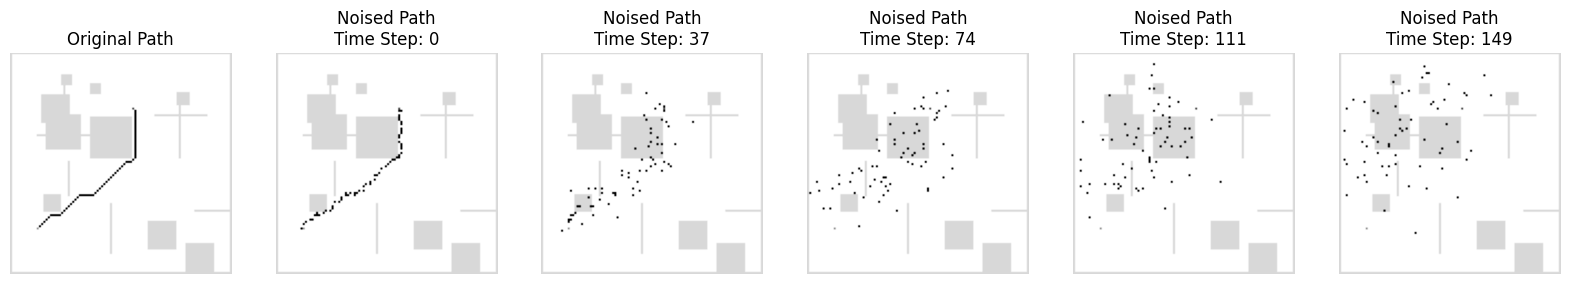

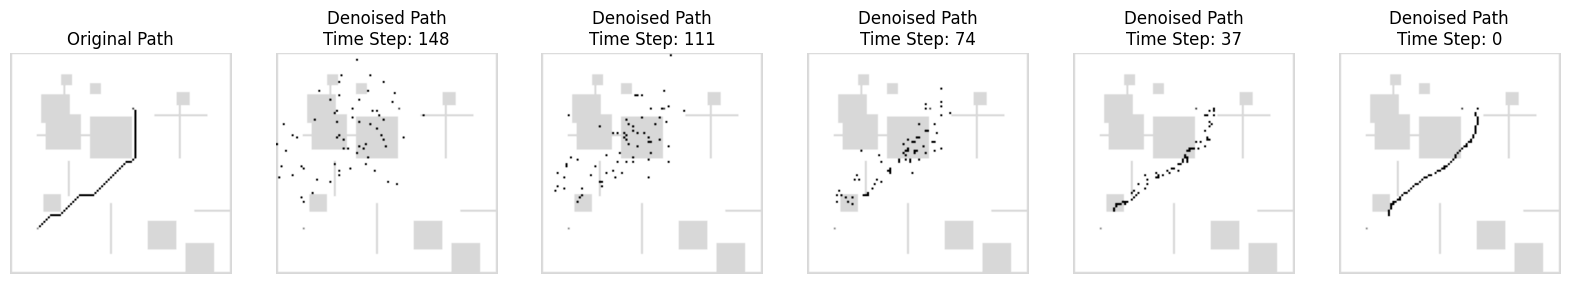

Epoch: 21 | Train Loss: 251.66440439224243
Epoch: 22 | Train Loss: 248.7831301689148
Epoch: 23 | Train Loss: 251.13197088241577
Epoch: 24 | Train Loss: 251.00406217575073
Epoch: 25 | Train Loss: 249.45565557479858
Epoch: 26 | Train Loss: 249.16586065292358
Epoch: 27 | Train Loss: 248.78789615631104
Epoch: 28 | Train Loss: 248.92646265029907
Epoch: 29 | Train Loss: 248.30437850952148
Epoch: 30 | Train Loss: 248.3645725250244
Epoch: 31 | Train Loss: 248.75854969024658
Epoch: 32 | Train Loss: 249.64326095581055
Epoch: 33 | Train Loss: 248.4476203918457
Epoch: 34 | Train Loss: 250.51610374450684
Epoch: 35 | Train Loss: 247.9642424583435
Epoch: 36 | Train Loss: 248.00608777999878
Epoch: 37 | Train Loss: 246.56976699829102
Epoch: 38 | Train Loss: 249.1080322265625
Epoch: 39 | Train Loss: 246.30752325057983
Epoch: 40 | Train Loss: 247.58052492141724


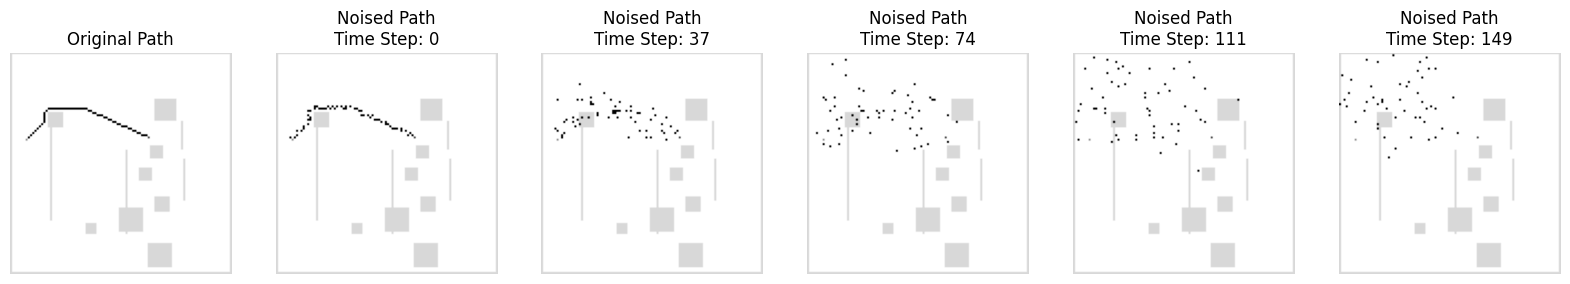

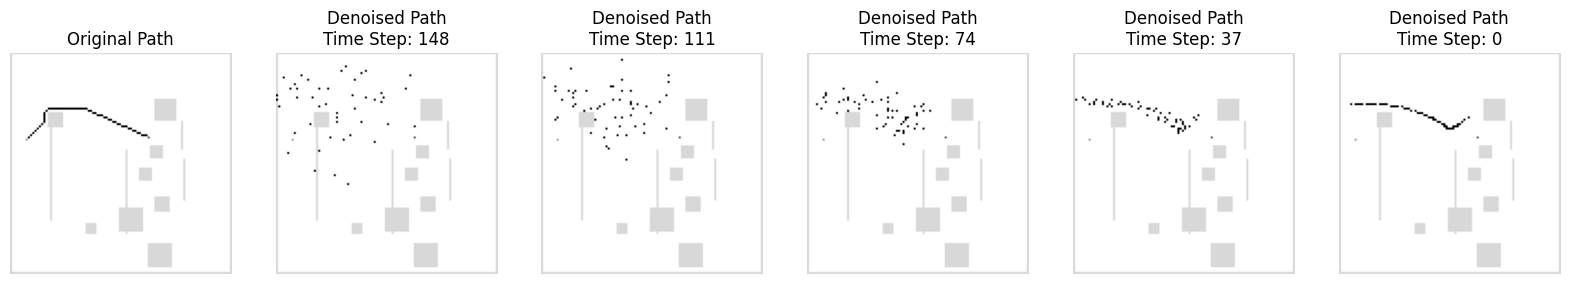

Epoch: 41 | Train Loss: 248.1479206085205
Epoch: 42 | Train Loss: 248.56065797805786
Epoch: 43 | Train Loss: 248.79455757141113
Epoch: 44 | Train Loss: 247.59060192108154
Epoch: 45 | Train Loss: 249.39888286590576
Epoch: 46 | Train Loss: 248.85728359222412
Epoch: 47 | Train Loss: 248.94755172729492
Epoch: 48 | Train Loss: 245.87878942489624
Epoch: 49 | Train Loss: 247.74367570877075
Epoch: 50 | Train Loss: 247.78067064285278
Epoch: 51 | Train Loss: 247.19423389434814
Epoch: 52 | Train Loss: 247.7214550971985
Epoch: 53 | Train Loss: 247.6042938232422
Epoch: 54 | Train Loss: 248.2840371131897
Epoch: 55 | Train Loss: 249.00925302505493
Epoch: 56 | Train Loss: 246.60542345046997
Epoch: 57 | Train Loss: 247.54101085662842
Epoch: 58 | Train Loss: 246.7678656578064
Epoch: 59 | Train Loss: 248.41735458374023
Epoch: 60 | Train Loss: 248.6863842010498


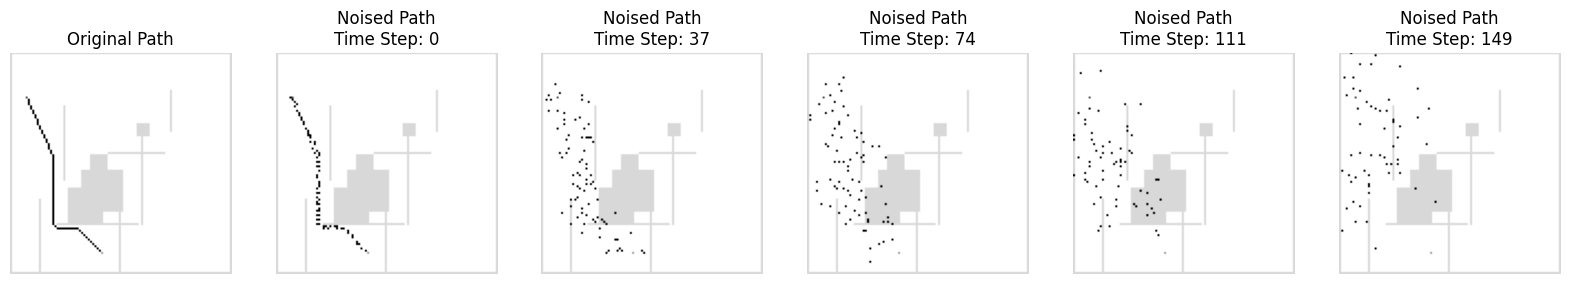

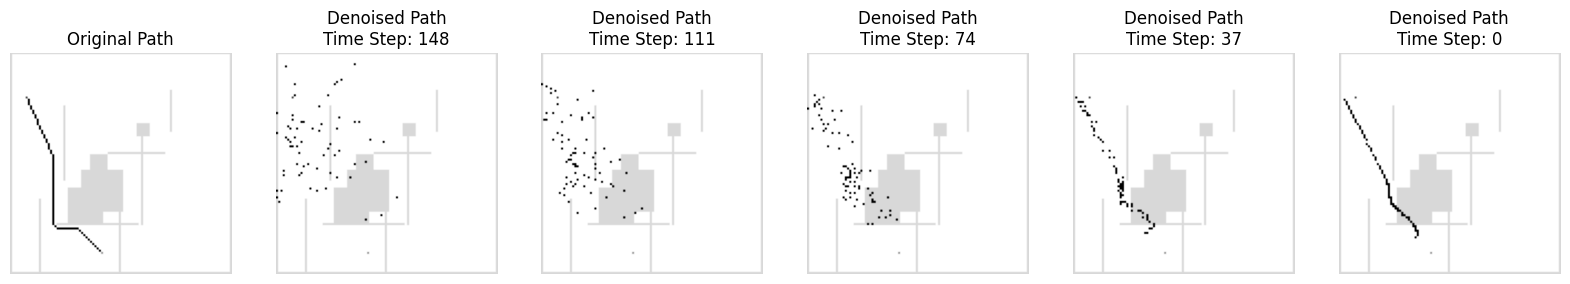

Epoch: 61 | Train Loss: 248.06588220596313
Epoch: 62 | Train Loss: 247.9291615486145
Epoch: 63 | Train Loss: 248.87338066101074
Epoch: 64 | Train Loss: 247.9517102241516
Epoch: 65 | Train Loss: 248.96910572052002
Epoch: 66 | Train Loss: 248.8931040763855
Epoch: 67 | Train Loss: 248.0565538406372
Epoch: 68 | Train Loss: 247.70300436019897
Epoch: 69 | Train Loss: 246.62684202194214
Epoch: 70 | Train Loss: 247.83095741271973
Epoch: 71 | Train Loss: 246.45410346984863
Epoch: 72 | Train Loss: 246.1849341392517
Epoch: 73 | Train Loss: 246.4592776298523
Epoch: 74 | Train Loss: 248.49089431762695
Epoch: 75 | Train Loss: 248.20846939086914
Epoch: 76 | Train Loss: 246.6617727279663
Epoch: 77 | Train Loss: 246.55368661880493
Epoch: 78 | Train Loss: 248.5071234703064
Epoch: 79 | Train Loss: 246.88757610321045
Epoch: 80 | Train Loss: 247.44170665740967


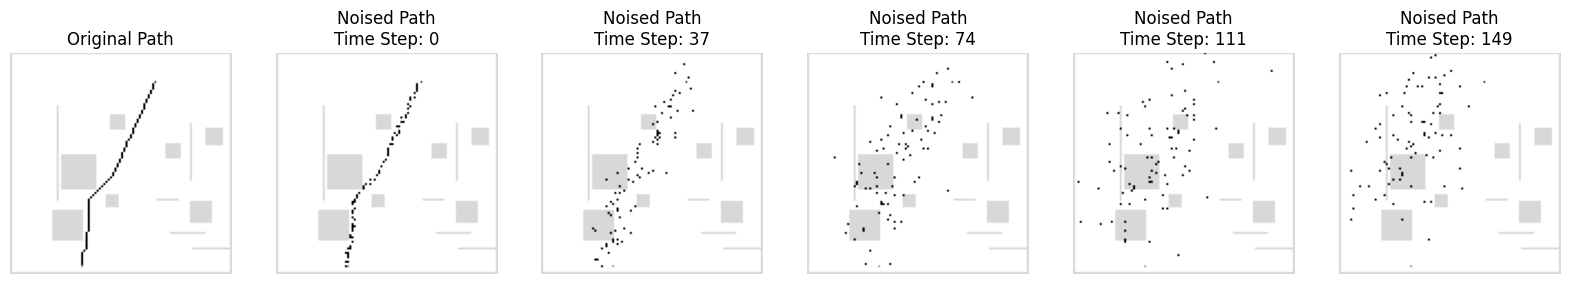

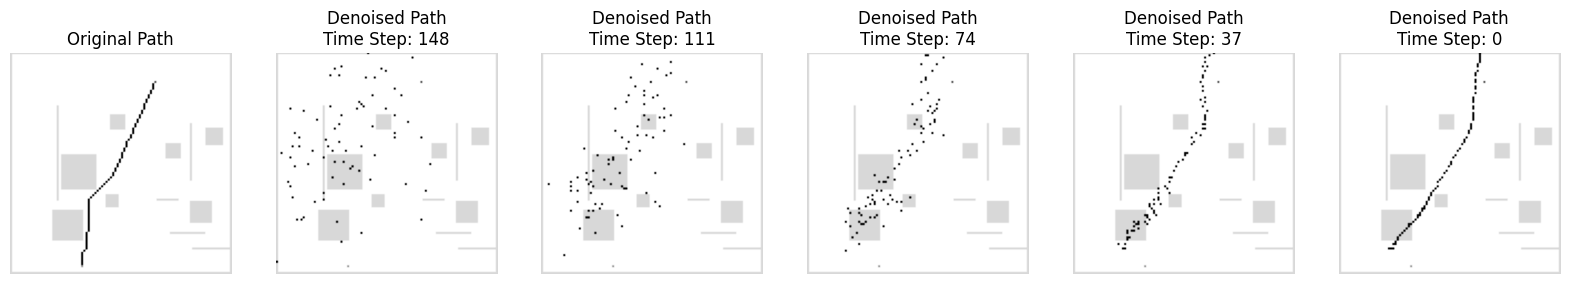

Epoch: 81 | Train Loss: 247.37272834777832
Epoch: 82 | Train Loss: 246.3452286720276
Epoch: 83 | Train Loss: 246.07396936416626
Epoch: 84 | Train Loss: 246.9914355278015
Epoch: 85 | Train Loss: 247.7770290374756
Epoch: 86 | Train Loss: 247.37932586669922
Epoch: 87 | Train Loss: 247.03540706634521
Epoch: 88 | Train Loss: 246.34037446975708
Epoch: 89 | Train Loss: 246.6972827911377
Epoch: 90 | Train Loss: 244.97574996948242
Epoch: 91 | Train Loss: 246.30115938186646
Epoch: 92 | Train Loss: 247.5483798980713
Epoch: 93 | Train Loss: 246.35923147201538
Epoch: 94 | Train Loss: 247.29128694534302
Epoch: 95 | Train Loss: 248.82229375839233
Epoch: 96 | Train Loss: 246.18233346939087
Epoch: 97 | Train Loss: 246.97631168365479
Epoch: 98 | Train Loss: 245.52446460723877
Epoch: 99 | Train Loss: 247.4960355758667


In [25]:
# Initialize the Unet Model
map_emb_dims = 512
input_channels = 2  # For the path data (x, y)
time_embedding_dims = 128
unet_model = UNet(input_channels, map_emb_dims, time_embedding_dims).to(device)
optimizer = optim.Adam(unet_model.parameters(), lr=1e-4)

# Initialize TensorBoard writer
writer = SummaryWriter("runs/diffusion_training_loss")

# Diffusion model setup
diffusion_model = DiffusionModel()

num_epochs = 100 # Number of epochs for training
print_frequency = 1  # Frequency of printing information
visualize_frequency = 20
num_timestep_display = 5

# Setup a small batch DataLoader for visualization
vis_dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# Load the pretrained ResNet model
pretrained_resnet18_model = models.resnet18(pretrained=True)
pretrained_resnet18_model.to(device)  # Move the model to the GPU if available

# Remove the fully connected layer to use the model as a feature extractor
resnet18_feature_extractor = nn.Sequential(*list(pretrained_resnet18_model.children())[:-1])
resnet18_feature_extractor.to(device)  # Ensure the feature extractor is also on the GPU

for epoch in range(num_epochs):
    train_loss = []
    val_loss = []
    for batch in dataloader:
        maps = batch['map'].to(device)
        astar_paths = batch['astar_path'].to(device)
        astar_masks = batch['astar_mask'].to(device)

        # Preprocess maps and extract embeddings using a pretrained ResNet18
        maps_preprocessed = preprocess_maps(maps)
        map_embeddings = resnet18_feature_extractor(maps_preprocessed)
        # Flatten embeddings
        map_embeddings = map_embeddings.view(map_embeddings.size(0), -1)

        # Get random timesteps
        t = torch.randint(0, diffusion_model.timesteps, (maps.size(0),)).long().to(device)
        # Get noised paths
        noisy_path_batch, actual_noise = diffusion_model.forward(astar_paths, t, astar_masks, device)
        # Permute noisy_path_batch to match [batch_size, channels, sequence_length]
        noisy_path_batch = noisy_path_batch.permute(0, 2, 1)

        # Pass data to UNet
        predicted_noise = unet_model(noisy_path_batch, map_embeddings, t)

        # Calculate loss
        optimizer.zero_grad()
        # Permute to change from torch.Size([32, 175, 2]) to torch.Size([32, 2, 175])
        actual_noise = actual_noise.permute(0, 2, 1)
        loss = torch.nn.functional.mse_loss(actual_noise, predicted_noise)
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())

    # Log the average training loss to TensorBoard
    writer.add_scalar("Training Loss", np.mean(train_loss), epoch)

    # Logging
    if epoch % print_frequency == 0:
        print(f"Epoch: {epoch} | Train Loss: {np.mean(train_loss)}") # | Val Loss: {np.mean(val_loss)}")
        # Save model checkpoints
        torch.save(unet_model.state_dict(), f"unet_model_epoch_{epoch}.pth")

    if epoch % visualize_frequency == 0:
        # Sample a batch of paths for visualization
        sample_data = next(iter(vis_dataloader))
        # Squeeze to get rid of batch dimension. We only need one sample
        sample_map = sample_data['map'].to(device).squeeze(0)
        sample_path = sample_data['astar_path'].to(device).squeeze(0)
        sample_mask = sample_data['astar_mask'].to(device).squeeze(0)


        # --- Noising Process:
        
        path_timestep_batch = sample_path.unsqueeze(0).repeat(num_timestep_display, 1, 1)
        t = torch.linspace(0, diffusion_model.timesteps - 1, num_timestep_display).long().to(device)

        noisy_path_timesteps_batch, _ = diffusion_model.forward(path_timestep_batch, t, sample_mask.unsqueeze(0), device)

        visualize_forward_diffusion(num_timestep_display, sample_path, noisy_path_timesteps_batch, sample_map, sample_mask, t)

        # --- Denoising Process:

        maps_preprocessed = preprocess_maps(sample_map)
        map_embeddings = resnet18_feature_extractor(maps_preprocessed)
        # Flatten embeddings
        map_embeddings = map_embeddings.view(map_embeddings.size(0), -1)

        # Get initial noised path
        t_max = diffusion_model.timesteps - 1
        t_tensor = torch.tensor([t_max], device=device)
        initial_noisy_path, _ = diffusion_model.forward(sample_path.unsqueeze(0), t_tensor, sample_mask.unsqueeze(0), device)

        # Collect denoised paths at specific timesteps
        denoised_path_timesteps_batch = []
        current_denoised_path = initial_noisy_path.permute(0,2,1)
        timestep_list = []

        # Denoise each timestep at a time in reverse
        for t in reversed(range(t_max + 1)):
            t_tensor = torch.tensor([t], device=device)
            current_denoised_path = diffusion_model.backward(current_denoised_path, t_tensor, map_embeddings, unet_model, device)
            
            # Collect paths at specific intervals to visualize
            if t % (t_max // (num_timestep_display - 1)) == 0 or t == 0:
                timestep_list.append(t)
                current_denoised_path_to_save = current_denoised_path.permute(0,2,1)
                denoised_path_timesteps_batch.append(current_denoised_path_to_save)

        # Concatenate the denoised paths along the first dimension
        denoised_path_timesteps_batch = torch.cat(denoised_path_timesteps_batch, dim=0)

        visualize_denoised_paths(num_timestep_display, sample_path, denoised_path_timesteps_batch, sample_map, sample_mask, timestep_list)



Tensorboard

In [3]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [4]:
%tensorboard --logdir=runs/diffusion_training_loss

Reusing TensorBoard on port 6006 (pid 3865), started 0:00:11 ago. (Use '!kill 3865' to kill it.)

Visualization

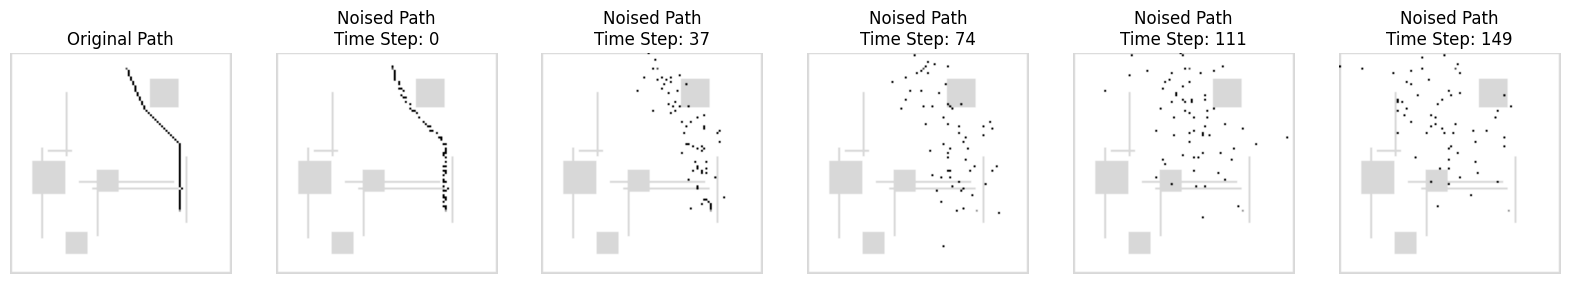

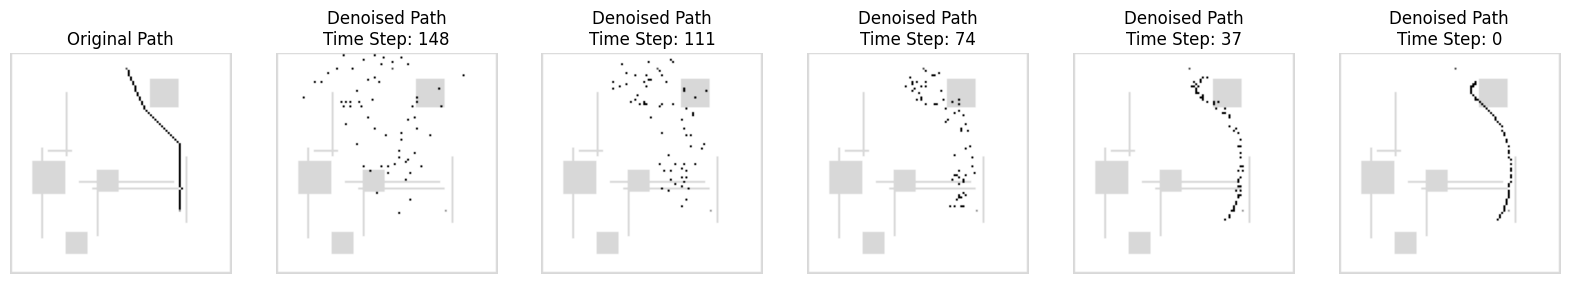

In [127]:
# Diffusion model setup
diffusion_model = DiffusionModel()

# Sample a batch of paths for visualization
sample_data = next(iter(vis_dataloader))
# Squeeze to get rid of batch dimension. We only need one sample
sample_map = sample_data['map'].to(device).squeeze(0)
sample_path = sample_data['astar_path'].to(device).squeeze(0)
sample_mask = sample_data['astar_mask'].to(device).squeeze(0)


# --- Noising Process:
 
path_timestep_batch = sample_path.unsqueeze(0).repeat(num_timestep_display, 1, 1)
t = torch.linspace(0, diffusion_model.timesteps - 1, num_timestep_display).long().to(device)

noisy_path_timesteps_batch, _ = diffusion_model.forward(path_timestep_batch, t, sample_mask.unsqueeze(0), device)

visualize_forward_diffusion(num_timestep_display, sample_path, noisy_path_timesteps_batch, sample_map, sample_mask, t)

# --- Denoising Process:

maps_preprocessed = preprocess_maps(sample_map)
map_embeddings = resnet18_feature_extractor(maps_preprocessed)
# Flatten embeddings
map_embeddings = map_embeddings.view(map_embeddings.size(0), -1)

# Get initial noised path
t_max = diffusion_model.timesteps - 1
t_tensor = torch.tensor([t_max], device=device)
initial_noisy_path, _ = diffusion_model.forward(sample_path.unsqueeze(0), t_tensor, sample_mask.unsqueeze(0), device)

# Collect denoised paths at specific timesteps
denoised_path_timesteps_batch = []
current_denoised_path = initial_noisy_path.permute(0,2,1)
timestep_list = []

# Denoise each timestep at a time in reverse
for t in reversed(range(t_max + 1)):
    t_tensor = torch.tensor([t], device=device)
    current_denoised_path = diffusion_model.backward(current_denoised_path, t_tensor, map_embeddings, unet_model, device)
    
    # Collect paths at specific intervals to visualize
    if t % (t_max // (num_timestep_display - 1)) == 0 or t == 0:
        timestep_list.append(t)
        current_denoised_path_to_save = current_denoised_path.permute(0,2,1)
        denoised_path_timesteps_batch.append(current_denoised_path_to_save)

# Concatenate the denoised paths along the first dimension
denoised_path_timesteps_batch = torch.cat(denoised_path_timesteps_batch, dim=0)

visualize_denoised_paths(num_timestep_display, sample_path, denoised_path_timesteps_batch, sample_map, sample_mask, timestep_list)

# maps_preprocessed = preprocess_maps(sample_map)
# map_embeddings = resnet18_feature_extractor(maps_preprocessed)
# # Flatten embeddings
# map_embeddings = map_embeddings.view(map_embeddings.size(0), -1)
# # Repeat embeddings to match the number of time steps
# map_embeddings = map_embeddings.repeat(num_timestep_display, 1)

# denoised_path_timesteps_batch = diffusion_model.backward(noisy_path_timesteps_batch, t, map_embeddings, unet_model, device)

# denoised_path_timesteps_batch = denoised_path_timesteps_batch.permute(0,2,1)
# visualize_denoised_paths(num_timestep_display, sample_path, denoised_path_timesteps_batch, sample_map, sample_mask)


# Extra

UNet Model

In [ ]:
# def double_conv(in_c, out_c):
#     conv = nn.Sequential(
#         nn.Conv1d(in_c, out_c, kernel_size=3),
#         nn.ReLU(inplace=True),
#         nn.Conv1d(out_c, out_c, kernel_size=3),
#         nn.ReLU(inplace=True)
#     )
#     return conv

# def crop_img(tensor, target_tensor):
#     target_size = target_tensor.size()[2]
#     tensor_size = tensor.size()[2]
#     delta = tensor_size - target_size
#     delta = delta // 2
#     return tensor[:,:, delta:tensor_size - delta, delta:tensor_size - delta]

# class UNetModel(nn.Module):
#     def __init__(self):
#         super(UNetModel, self).__init__()

#         # Use MaxPool 1D Since out embeddings are 1 dimensional
#         self.max_pool_1x2 = nn.MaxPool1d(kernel_size=2, stride=2)

#         # Input 1 dimension and output 64
#         self.down_conv_1 = double_conv(1,64)
#         self.down_conv_2 = double_conv(64,128)
#         self.down_conv_3 = double_conv(128,256)
#         self.down_conv_4 = double_conv(256,512)
#         self.down_conv_5 = double_conv(512,1024)

#         self.up_trans_1 = nn.ConvTranspose2d(
#             in_channels=1024,
#             out_channels=512,
#             kernel_size=2,
#             stride=2)

#         self.up_conv_1 = double_conv(1024,512)


#         self.up_trans_2 = nn.ConvTranspose2d(
#             in_channels=512,
#             out_channels=256,
#             kernel_size=2,
#             stride=2)

#         self.up_conv_2 = double_conv(512,256)


#         self.up_trans_3 = nn.ConvTranspose2d(
#             in_channels=256,
#             out_channels=128,
#             kernel_size=2,
#             stride=2)

#         self.up_conv_3 = double_conv(256,128)


#         self.up_trans_4 = nn.ConvTranspose2d(
#             in_channels=128,
#             out_channels=64,
#             kernel_size=2,
#             stride=2)

#         self.up_conv_4 = double_conv(128,64)

#         self.out = nn.Conv2d(
#             in_channels=64,
#             out_channels=2,
#             kernel_size=1
#         )


#     def forward(self, map_embedding):
#         # Reshape from [batch_size, 512] to [batch_size, 1, 512]
#         map_embedding = map_embedding.unsqueeze(1)

#         # encoder
#         x1 = self.down_conv_1(map_embedding) #
#         x2 = self.max_pool_1x2(x1)
#         x3 = self.down_conv_2(x2) #
#         x4 = self.max_pool_1x2(x3)
#         x5 = self.down_conv_3(x4) #
#         x6 = self.max_pool_1x2(x5)
#         x7 = self.down_conv_4(x6) #
#         x8 = self.max_pool_1x2(x7)
#         x9 = self.down_conv_5(x8) #
#         # return x9

#         #decoder
#         x = self.up_trans_1(x9)
#         y = crop_img(x7,x)
#         x = self.up_conv_1(torch.cat([x, y]), 1)


#         x = self.up_trans_2(x9)
#         y = crop_img(x5,x)
#         x = self.up_conv_1(torch.cat([x, y]), 1)

#         x = self.up_trans_3(x9)
#         y = crop_img(x3,x)
#         x = self.up_conv_1(torch.cat([x, y]), 1)

#         x = self.up_trans_4(x9)
#         y = crop_img(x1,x)
#         x = self.up_conv_1(torch.cat([x, y]), 1)

#         x = self.out(x)
#         return x

# --------------------------------------------------
# -------------------------------------------------

# def double_conv(in_c, out_c):
#     conv = nn.Sequential(
#         nn.Conv1d(in_c, out_c, kernel_size=3),
#         nn.ReLU(inplace=True),
#         nn.Conv1d(out_c, out_c, kernel_size=3),
#         nn.ReLU(inplace=True)
#     )
#     return conv

# class UNetModel(nn.Module):
#     def __init__(self):
#         super(UNetModel, self).__init__()

#         # Input 1 dimension and output 64
#         self.down_conv_1 = double_conv(1,64)
#         # Use MaxPool 1D Since out embeddings are 1 dimensional
#         self.max_pool_1x2 = nn.MaxPool1d(kernel_size=2, stride=2)

#     def forward(self, map_embedding):
#         # Reshape from [batch_size, 512] to [batch_size, 1, 512]
#         map_embedding = map_embedding.unsqueeze(1)

#         # encoder
#         x1 = self.down_conv_1(map_embedding)
#         x2 = self.max_pool_1x2(x1)
#         return x2
